# Grapheme2Phoneme Translation with an Encoder-Decoder Model

Grapheme-to-phoneme (G2P) is used to convert words (sequences of grapheme's in a specific language's script) into sequences of IPA units. In this work, we build a G2P model that is trained on and can be applied to a large number of languages (even low-resource ones).

## Preliminaries

We start by importing some libraries (including pyTorch v1.4.0), and defining some variables and hyperparameters which will be used later.

In [1]:
from torch.utils.data import DataLoader, Dataset
from functools import partial

import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch import nn, optim
from tqdm import tqdm

import pickle as pkl

import random
random.seed(42)

In [2]:
PAD = "<PAD>"
UNK = "<UNK>"
BOS = "<BOS>"
EOS = "<EOS>"

BATCH_SIZE = 32
LR = 1e-3
L2_NORM = 1e-5
EMBED_DIM = 300
HIDDEN_DIM = 256
NUM_LAYERS = 2
EPOCHS = 10
BEAM_WIDTH = 5
checkpt_filename = 'saved_models/seq2seq-{}layer.ckpt'.format(NUM_LAYERS)


## Preparing the Data

We begin by loading the provided data. The important elements for each data point are the grapheme sequence, phoneme sequence, and language (stored as iso-script)

In [3]:
def load_data(filename):
    f = open(filename)
    data = [x.strip('\n').split('\t') for x in f.readlines()]
    data = [[list(x[2]), x[3].split(), "-".join([x[0], x[1]])] for x in data]
    return data

In [4]:
train_filename = 'pron_data/gold_data_train'
test_filename = 'pron_data/gold_data_test'

train_data = load_data(train_filename)
test_data = load_data(test_filename)
random.shuffle(train_data)

We now build our vocabularies for graphemes and phonemes, as well as a list of languages. These language tokens will be concatenated to the grapheme sequence, and are thus included in the grapheme vocabulary

In [5]:
from collections import defaultdict

grapheme_freq_dict = defaultdict(int)
phoneme_freq_dict = defaultdict(int)

for d in train_data+test_data:
    for g in d[0]:
        grapheme_freq_dict[g] += 1
    for p in d[1]:
        phoneme_freq_dict[p] += 1

langs_list_train = []
for d in train_data:
    langs_list_train.append(d[2])
langs_list_train = sorted(list(set(langs_list_train)))
    
grapheme_vocab = [PAD, UNK, BOS, EOS] + sorted(list(grapheme_freq_dict.keys()))
phoneme_vocab = [PAD, UNK, BOS, EOS] + sorted(list(phoneme_freq_dict.keys()))

langs_list = langs_list_train
print("Number of languages: {}".format(len(langs_list)))
grapheme_vocab += langs_list

print("Size of grapheme vocab: {}".format(len(grapheme_vocab)))
print("Size of phoneme vocab: {}".format(len(phoneme_vocab)))

Number of languages: 420
Size of grapheme vocab: 4690
Size of phoneme vocab: 569


We now define our G2PDataset class. Since the testing data might contain languages which are not present in the training data, we replace their language tokens with UNK. The dataset yields batches with grapheme and phoneme sequences, as well as the lengths of the grapheme sequence. 

The grapheme sequence has the language token prepended - this resulted in significant performance gains (~5% PER improvement on the validation set, ~10% PER improvement on the test set). An example input sequence would thus be:
`eng-Latin` `z` `e` `r` `o`

We use 10% of our training data as the validation set, while the remainder is used for training

In [6]:
class G2PDataset(Dataset):
    
    def __init__(self, g2p_data, grapheme_vocab, phoneme_vocab):
        self.data = g2p_data
        self.grapheme_vocab = grapheme_vocab
        self.phoneme_vocab = phoneme_vocab
        for i in range(len(self.data)):
            if self.data[i][2] not in grapheme_vocab:
                self.data[i][2] = UNK
        self.g2i = {g: grapheme_vocab.index(g) for g in grapheme_vocab}
        self.p2i = {p: phoneme_vocab.index(p) for p in phoneme_vocab}
        self.i2p = {phoneme_vocab.index(p): p for p in phoneme_vocab}

    def __getitem__(self, index):
        return {'G': torch.tensor([self.g2i[self.data[index][2]]] + [self.g2i[g] for g in self.data[index][0]]), 
                'P': torch.tensor([self.p2i[p] for p in ([BOS]+self.data[index][1]+[EOS])]),
                'G_len': len(self.data[index][0]),
                'lang': self.data[index][2]}
    
    def __len__(self):
        return len(self.data)

train_data_size = int(0.9*len(train_data))
train_dataset = G2PDataset(train_data[:train_data_size], grapheme_vocab, phoneme_vocab)
val_dataset = G2PDataset(train_data[train_data_size:], grapheme_vocab, phoneme_vocab)
test_dataset = G2PDataset(test_data, grapheme_vocab, phoneme_vocab)

We define iterators for each of our datasets. The collate function handles the padding using the PAD token

In [7]:
def pad_sequence_batch(batch, dataset):
    g_seqs = [x['G'] for x in batch]
    p_seqs = [x['P'] for x in batch]
    g_lens = [x['G_len'] for x in batch]
    langs = [x['lang'] for x in batch]
    return {'G': pad_sequence(g_seqs, batch_first=True, padding_value=dataset.g2i[PAD]),
            'P': pad_sequence(p_seqs, batch_first=True, padding_value=dataset.p2i[PAD]), 
            'G_lens': g_lens, 
            'langs': langs}

train_iterator = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True, 
                            collate_fn=partial(pad_sequence_batch, dataset = train_dataset))

val_iterator = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, 
                          collate_fn=partial(pad_sequence_batch, dataset = train_dataset))

test_iterator = DataLoader(test_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=False, 
                           collate_fn=partial(pad_sequence_batch, dataset = train_dataset))

## Creating the Model

Our model is a Seq2Seq/Encoder-Decoder model. Encoder-Decoder models are standard for similar sequence-to-sequence tasks like Machine Translations. We use RNNs in our Encoders and Decoders instead of Transformers, since these are generally less parameter-intensive.

The Encoder is a 2-layer LSTM, with 300-dim embeddings and 256-dim hidden state

In [8]:
class Encoder(nn.Module):
    def __init__(self, emb_size, hid_size, num_layers, grapheme_vocab):
        super(Encoder, self).__init__() 
        vocab_size = len(grapheme_vocab)
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=grapheme_vocab.index(PAD))
        self.encoder = nn.LSTM(emb_size, hid_size, num_layers, batch_first=True)
        
    def forward(self, seqs, lens):
        
        # Extract grapheme embeddings
        embs = self.embedding(seqs)
        
        # Before passing through the LSTM, we pack the padded embeddings 
        sort_idx = sorted(range(len(lens)), key=lambda i: -lens[i])
        sorted_embs = embs[sort_idx]
        sorted_lens = [lens[i] for i in sort_idx]
        packed = pack_padded_sequence(sorted_embs, sorted_lens, batch_first=True)
        sorted_outputs, sorted_hidden = self.encoder(packed)
        sorted_outputs, _ = pad_packed_sequence(sorted_outputs, batch_first=True)
        unsort_idx = sorted(range(len(lens)), key=lambda i: sort_idx[i])
        outputs = sorted_outputs[unsort_idx]
        hidden = (sorted_hidden[0][:,unsort_idx], sorted_hidden[1][:,unsort_idx])
        return outputs, hidden


        

The decoder is a 2-layer GRU, with dropout after the phoneme embeddings.

In [9]:
class Decoder(nn.Module):
    def __init__(self, emb_size, hid_size, num_layers, phoneme_vocab, dropout_p=0.3):
        super(Decoder, self).__init__()
        vocab_size = len(phoneme_vocab)
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.dropout = nn.Dropout(dropout_p)
        self.decoder = nn.GRU(emb_size, hid_size, num_layers)
        self.out = nn.Linear(hid_size, vocab_size)
        
    def forward(self, hidden, last_word, encoder_outputs):
        emb = self.embedding(last_word).unsqueeze(0)
        emb = self.dropout(emb)
        output, hidden = self.decoder(emb, hidden)
        return F.log_softmax(self.out(output), dim=2), hidden

We also have a decoder which uses attention (Bahdanau et al., 2015); however, our primary results are obtained without attention since the benefits of attention for this task were very marginal.

In [10]:
class AttnDecoder(nn.Module):
    def __init__(self, emb_size, hid_size, num_layers, phoneme_vocab, dropout_p=0.3):
        super(AttnDecoder, self).__init__()
        vocab_size = len(phoneme_vocab)
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.attn_Wa = nn.Linear(hid_size*2, hid_size)
        self.attn_v = nn.Linear(hid_size, 1)
        self.dropout = nn.Dropout(dropout_p)
        self.decoder = nn.GRU(emb_size+hid_size, hid_size, num_layers)
        self.out = nn.Linear(hid_size, vocab_size)
        
    def forward(self, hidden, last_word, encoder_outputs):
        emb = self.embedding(last_word).unsqueeze(0)
        
        h = hidden[-1].unsqueeze(0).permute(1,0,2).repeat(1, encoder_outputs.shape[1], 1)
        attn_energies = torch.tanh(self.attn_Wa(torch.cat((h, encoder_outputs), dim=2)))
        attn_logits = self.attn_v(attn_energies)
        attn_weights = F.softmax(attn_logits, dim=1)
        context_vec = torch.bmm(attn_weights.permute(0,2,1), encoder_outputs).permute(1,0,2)

        emb = torch.cat((emb, context_vec), dim=2)
        emb = self.dropout(emb)
        output, hidden = self.decoder(emb, hidden)
        return F.log_softmax(self.out(output), dim=2), hidden

Our overall Seq2Seq model thus consists of our above defined Encoder and Decoder. We also define two methods for testing - `decode()` performs greedy decoding, whereas `beam_decode()` performs beam search decoding. The implementation of `beam_decode()` operates on a single grapheme sequence rather than a batch - batching the beam search would result in significant speed improvements.

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, emb_size, hid_size, num_layers, grapheme_vocab, phoneme_vocab, max_len=30):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(emb_size, hid_size, num_layers, grapheme_vocab)
        self.decoder = Decoder(emb_size, hid_size, num_layers, phoneme_vocab)
        #self.decoder = AttnDecoder(emb_size, hid_size, num_layers, phoneme_vocab)
        self.max_len = max_len
        
    def forward(self, grapheme_seq, phoneme_seq, g_lens):
        
        #print("phoneme seq:", phoneme_seq.shape)
        enc_outputs, enc_hidden = self.encoder(grapheme_seq, g_lens)
        dec_hidden = enc_hidden[1]
        
        probs = torch.zeros(phoneme_seq.shape[0], phoneme_seq.shape[1], len(phoneme_vocab))
        #print("probs shape:", probs.shape)
        last_word = phoneme_seq[:,0]
        for t in range(1, phoneme_seq.shape[1]):
            dec_output, dec_hidden = self.decoder(dec_hidden, last_word, enc_outputs)
            probs[:,t,:] = dec_output.squeeze(0)
            last_word = phoneme_seq[:,t]

        return probs
    
    def decode(self, grapheme_seq, g_lens):
        
        batch_size = len(g_lens)
        enc_outputs, enc_hidden = self.encoder(grapheme_seq, g_lens)
        dec_hidden = enc_hidden[1]
        
        predictions = torch.zeros(grapheme_seq.shape[0], self.max_len)
        last_word = torch.LongTensor([phoneme_vocab.index(BOS) for i in range(batch_size)]).to(device)
        for t in range(1, self.max_len):
            dec_output, dec_hidden = self.decoder(dec_hidden, last_word, enc_outputs)
            
            topv, topi = dec_output.data.topk(1)
            topi = topi.view(-1)
            predictions[:, t] = topi
            last_word = topi.detach()
            
        return predictions

    def beam_decode(self, grapheme_seq, g_lens, beam_width):
        # batch size must be 1
        batch_size = len(g_lens)
        grapheme_seq = grapheme_seq.unsqueeze(0)

        enc_outputs, enc_hidden = self.encoder(grapheme_seq, g_lens)
        dec_hidden = enc_hidden[1]
        
        last_word = torch.LongTensor([phoneme_vocab.index(BOS)]).to(device)
        init_hyp = {'last_word': last_word, 
                    'log_p': 0.0, 
                    'length': 0, 
                    'seq': [phoneme_vocab.index(BOS)], 
                    'dec_hidden': dec_hidden}
        beam = [init_hyp]
        for t in range(1, self.max_len):
            new_beam = []
            for hyp in beam:

                if hyp['seq'][-1] == phoneme_vocab.index(EOS):
                    new_beam.append(hyp)
                    continue
                
                dec_output, dec_hidden = self.decoder(hyp['dec_hidden'], hyp['last_word'], enc_outputs)
                topv, topi = dec_output.data.topk(beam_width)
                topi = topi.view(-1)
                topv = topv.view(-1)
                for i in range(beam_width):
                    last_word = torch.LongTensor([topi[i].detach()]).to(device)
                    new_hyp = {'last_word': last_word, 
                               'log_p': hyp['log_p']+topv[i].item(), 
                               'length': hyp['length']+1, 
                               'seq': hyp['seq']+[topi[i].item()], 
                               'dec_hidden': dec_hidden}
                    new_beam.append(new_hyp)

            beam = sorted(new_beam, 
                          key=lambda x: x['log_p']/x['length'], 
                          reverse=True)
            beam = beam[:beam_width]
            
        return [h['seq'] for h in beam]
            
        

We define two methods to turn our decoding outputs into a string sequence of phonemes. We also define a method for our evaluation metric - Phoneme Error Rate (PER). PER is equal to the sum of Levenshtein edit distance of all samples in the test set, divided by the sum of reference phoneme sequence lengths. This metric is similar to Word Error Rate/Character Error Rate which are used to evaluate speech recognition systems.

In [12]:
import Levenshtein

def get_sequences(out_tensor, i2p):
    out_seqs = []
    for i in range(out_tensor.shape[0]):
        seq = []
        for t in range(out_tensor.shape[1]):
            p = i2p[out_tensor[i][t].item()]
            if p == EOS:
                break
            seq.append(p)
        out_seqs.append(''.join(seq[1:]))
    return out_seqs

def get_beam_sequences(out_matrix, i2p):
    out_seqs = []
    for i in range(len(out_matrix)):
        seq = []
        for t in range(len(out_matrix[i])):
            p = i2p[out_matrix[i][t]]
            if p == EOS:
                break
            seq.append(p)
        out_seqs.append(''.join(seq[1:]))
    return out_seqs

def phoneme_error_rate(predicted_seqs, reference_seqs):
    num_samples = len(predicted_seqs)
    ref_len = 0
    edit_distance = 0
    for pred, ref in zip(predicted_seqs, reference_seqs):
        edit_distance += Levenshtein.distance(''.join(pred), ''.join(ref))
        ref_len += len(ref)
        
    return 100.0*edit_distance/ref_len


Which create an instance of our Seq2Seq model using the hyperparameters declared in the beginning, as well as a loss criterion and optimizer. We use weight decay for regularization.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
#model = Encoder(100, 100, grapheme_vocab)
model = Seq2Seq(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, grapheme_vocab, phoneme_vocab)
model.to(device)

criterion = nn.NLLLoss(ignore_index=phoneme_vocab.index(PAD), size_average=True)
optimizer = optim.Adam(lr=LR, params=model.parameters(), weight_decay=L2_NORM)

/home/tsriniva/anaconda2/envs/ethics_env/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Now that we have created the model, we train it! After each epoch, we compute the validation PER (using greedy decoding), and save the model checkpoint if the validation PER is better (lower) than previous epoch checkpoints.

In [14]:
losses_list = []
best_per = 100.0
for epoch in range(EPOCHS):
    model.train()
    for batch in tqdm(train_iterator, desc="Training epoch {}".format(epoch)):
        optimizer.zero_grad()
        g = batch['G'].to(device)
        p = batch['P'].to(device)
        g_lens = batch['G_lens']

        decode_probs = model(g, p, g_lens).to(device)

        loss = criterion(decode_probs.view(-1, decode_probs.size(-1)), p.flatten())
        loss.backward()
        optimizer.step()
        losses_list.append(loss.item())
        
    model.eval()
    predicted_phoneme_seqs = []
    reference_phoneme_seqs = []
    for batch in tqdm(val_iterator):
        optimizer.zero_grad()
        g = batch['G'].to(device)
        p = batch['P'].to(device)
        g_lens = batch['G_lens']

        preds = model.decode(g, g_lens)

        pred_seqs = get_sequences(preds, test_dataset.i2p)
        ref_seqs = get_sequences(p, test_dataset.i2p)
        predicted_phoneme_seqs.extend(pred_seqs)
        reference_phoneme_seqs.extend(ref_seqs)
    per = phoneme_error_rate(predicted_phoneme_seqs, reference_phoneme_seqs)
    print("Epoch {}: Val PER = {:.2f}%".format(epoch, per))
    if per < best_per:
        print("Saving model...")
        torch.save(model.state_dict(), checkpt_filename)
        best_per = per


100%|██████████| 1975/1975 [00:40<00:00, 48.61it/s]


Epoch 0: Val PER = 20.40%
Saving model...


100%|██████████| 1975/1975 [00:40<00:00, 48.49it/s]


Epoch 1: Val PER = 17.50%
Saving model...


100%|██████████| 1975/1975 [00:40<00:00, 48.54it/s]


Epoch 2: Val PER = 16.59%
Saving model...


100%|██████████| 1975/1975 [00:40<00:00, 48.61it/s]


Epoch 3: Val PER = 15.95%
Saving model...


100%|██████████| 1975/1975 [00:40<00:00, 48.56it/s]


Epoch 4: Val PER = 15.59%
Saving model...


100%|██████████| 1975/1975 [00:40<00:00, 48.46it/s]


Epoch 5: Val PER = 15.47%
Saving model...


100%|██████████| 1975/1975 [00:40<00:00, 48.56it/s]


Epoch 6: Val PER = 15.15%
Saving model...


Training epoch 8:   0%|          | 3/17771 [00:00<11:32, 25.65it/s]

Epoch 7: Val PER = 15.36%


100%|██████████| 1975/1975 [00:39<00:00, 49.78it/s]


Epoch 8: Val PER = 14.93%
Saving model...


100%|██████████| 1975/1975 [00:38<00:00, 51.05it/s]


Epoch 9: Val PER = 14.92%
Saving model...


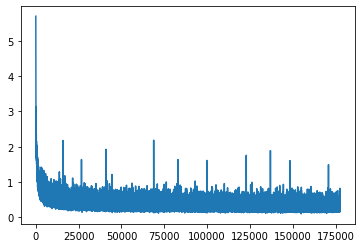

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses_list)
plt.show()

We now evaluate our model on the provided test set using both greedy and beam search decoding. We see that beam search doesn't result in much improvements in terms of PER, but takes significantly longer (10 minutes, compared to 15 seconds for greedy decoding) - however, it does provide multiple hypotheses with probabilities (although only the top hypothesis is used for evaluation). An alternative method to get multiple hypotheses would be *nucleus sampling*.

In [16]:
def evaluate_model(model, data_iterator, beam_decode=False):
    model.eval()
    predicted_phoneme_seqs = []
    reference_phoneme_seqs = []
    model.load_state_dict(torch.load(checkpt_filename))
    for batch in tqdm(data_iterator):
        g = batch['G'].to(device)
        p = batch['P'].to(device)
        g_lens = batch['G_lens']
        langs = batch['langs']

        if beam_decode is True:
            pred_seqs = []
            for j in range(len(g_lens)):
                hyps = model.beam_decode(g[j], [g_lens[j]], BEAM_WIDTH)
                pred_seqs.extend(get_beam_sequences([hyps[0]], test_dataset.i2p))
        else:
            preds = model.decode(g, g_lens)
            pred_seqs = get_sequences(preds, test_dataset.i2p)

        ref_seqs = get_sequences(p, test_dataset.i2p)

        predicted_phoneme_seqs.extend(pred_seqs)
        reference_phoneme_seqs.extend(ref_seqs)

    #print("Number of samples: {}".format(len(predicted_phoneme_seqs)))
    per = phoneme_error_rate(predicted_phoneme_seqs, reference_phoneme_seqs)
    #print("PER = {:.2f}%".format(per))
    return per, predicted_phoneme_seqs, reference_phoneme_seqs
    

In [17]:
test_per_greedy, predicted_phoneme_seqs, reference_phoneme_seqs  = evaluate_model(model, test_iterator, beam_decode=False)
print("Test PER for greedy search: {:.2f}%".format(test_per_greedy))

test_per_beam, _, _ = evaluate_model(model, test_iterator, beam_decode=True)
print("Test PER for beam search: {:.2f}%".format(test_per_beam))

  0%|          | 0/810 [00:00<?, ?it/s]

Test PER for greedy search: 38.83%


100%|██████████| 810/810 [09:26<00:00,  1.43it/s]

Test PER for beam search: 39.03%


The PER for a testing dataset of more than 500 languages lies at around 39%. These results are comparable to [this paper](https://www.aclweb.org/anthology/P16-1038.pdf) (Table 8), which also does grapheme-to-phoneme conversion for a large set of languages.

We see that beam search doesn't result in much improvements in terms of PER, but takes significantly longer (10 minutes, compared to 15 seconds for greedy decoding) - however, it does provide multiple hypotheses with probabilities (although only the top hypothesis is used for evaluation). An alternative method to get multiple hypotheses would be *nucleus sampling*.

Some examples of predicted and reference phoneme sequences:

In [18]:
for i in range(10):
    print(predicted_phoneme_seqs[i], reference_phoneme_seqs[i])

kakwə kɑkwəʔ
kaksu ħʌɖʌ
laɡo laɡo
ni ni
ha hu
huɔt huok
kiɔn kioɾ
naju nɑis
nweju nueik
nwɔt nuop


In [19]:
total_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: {}".format(total_params))

Number of parameters: 3644957


## Discussion

### Comparison of Network Complexity

The above model has 2 layers in both the encoder and decoder. We experiment with different number of layers to investigate the performance-efficiency tradeoff - fewer layers will result in smaller models and faster decoding, but might lead to performance drop.

| # layers | #params | Test PER  (greedy) | Val PER (greedy) | Training time per epoch | Test decoding time (beam) |
|----------|---------|--------------------|------------------|--------------------------|---------------------------|
| 1        | 2.7M    |  39.97%            |    15.94%        |  10 mins                 |    9 mins              |
| 2        | 3.6M    |  38.83%            |    14.92%        |  12 mins                 |    9.5 mins            |
| 3        | 4.5M    |  37.82%            |    14.39%        |  14 mins                 |    10 mins             |

We see that the models with more layers have lower validation and testing PER, but take slightly longer to both train and decode. We see that with a 20% reduction in parameters, our test PER drops by only 1%.

### Seq2Seq with Attention

| Attention | #params | Test PER  (greedy) | Val PER  (greedy) | Training time  per epoch | Test decoding time (beam) |
|-----------|---------|--------------------|-------------------|--------------------------|--------------------------|
| No        | 3.6M    | 38.83%             | 14.92%            | 12 mins                  | 9.5 mins                 |
| Yes       | 4.0M    | 38.23%             | 14.76%            | 17 mins                  | 13 mins                  |

We see that attention results in longer training and testing times, as well as a 10% increase in parameteres, which minimal PER improvements.

### Disparity between Validation and Test Performance

There is a large different between the PER over the validation and test set. This suggests different data distributions in our training set (which our val set is a subset of) and the testing data. One factor could be languages present in the test set which weren't seen during training: indeed, ~4% of test samples (1k out of 25k) belong to a language which is not represented in the training data. 

Another reason is overfitting. We have a regularization term (L2 norm): however, experiments with different hyperparameters did not yield improvements on the test score

Another possibility is that it performs differently on high-resource and low-resource data in the two datasets. Analyzing the performance on top-50 and other languages, we see that our model performs poorly on low-resource languages in both datasets, but the test set has more low-resource languages than the training data.

In [28]:
lang_freq = defaultdict(int)
for d in train_data:
    lang_freq[d[2]] += 1
top_50_langs = sorted(list(lang_freq.keys()), key=lambda x: lang_freq[x], reverse=True)[:50]


def evaluate_model_langwise(model, data_iterator, langs_list, beam_decode=False):
    model.eval()
    predicted_seqs_toplangs = []
    reference_seqs_toplangs = []
    predicted_seqs_otherlangs = []
    reference_seqs_otherlangs = []

    model.load_state_dict(torch.load(checkpt_filename))
    for batch in tqdm(data_iterator):
        g = batch['G'].to(device)
        p = batch['P'].to(device)
        g_lens = batch['G_lens']
        langs = batch['langs']

        preds = model.decode(g, g_lens)
        pred_seqs = get_sequences(preds, test_dataset.i2p)
        ref_seqs = get_sequences(p, test_dataset.i2p)

        for i, l in enumerate(langs):
            if l in langs_list:
                predicted_seqs_toplangs.append(pred_seqs[i])
                reference_seqs_toplangs.append(ref_seqs[i])
            else:
                predicted_seqs_otherlangs.append(pred_seqs[i])
                reference_seqs_otherlangs.append(ref_seqs[i])


    print("% of samples in top languages: {:.2f}%".format(100.0*len(predicted_seqs_toplangs)/(len(predicted_seqs_toplangs)+len(predicted_seqs_otherlangs))))
    toplangs_per = phoneme_error_rate(predicted_seqs_toplangs, reference_seqs_toplangs)
    otherlangs_per = phoneme_error_rate(predicted_seqs_otherlangs, reference_seqs_otherlangs)
    print("Top languages PER = {:.2f}%".format(toplangs_per))
    print("Other languages PER = {:.2f}%".format(otherlangs_per))
    
print("Validation:")
evaluate_model_langwise(model, val_iterator, top_50_langs)
print('-----------------------')
print('Testing:')
evaluate_model_langwise(model, test_iterator, top_50_langs)

  0%|          | 6/1975 [00:00<00:38, 51.78it/s]

Validation:


  0%|          | 0/810 [00:00<?, ?it/s]

% of samples in top languages: 97.57%
Top languages PER = 14.34%
Other languages PER = 50.42%
-----------------------
Testing:


100%|██████████| 810/810 [00:14<00:00, 57.49it/s]

% of samples in top languages: 35.47%
Top languages PER = 22.49%
Other languages PER = 50.67%
